
# Data Ingestion for Fake News Detection


## Why Data Ingestion is Important

In fake news detection, proper data ingestion ensures:
1. Data quality and consistency
2. Appropriate labeling of real and fake news articles
3. Balanced representation of both classes
4. Efficient storage for distributed processing


## Setup and Imports

First, let's set up our Spark environment and import the necessary libraries.

In [0]:
# Import required libraries
import os
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, lower, regexp_replace, rand, when, concat
from pyspark.sql.types import StringType, IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns


## Creating a Spark Session with Hive Support

We'll use Apache Spark for distributed data processing, with Hive support enabled to access the metastore tables. Let's create a properly configured Spark session optimized for the Databricks Community Edition limitations (1 driver, 15.3 GB Memory, 2 Cores).

In [0]:

# Create a Spark session with configuration optimized for Databricks Community Edition
# - appName: Identifies this application in the Spark UI and logs
# - spark.sql.shuffle.partitions: Set to 8 (4x number of cores) for Community Edition
# - spark.driver.memory: Set to 8g to utilize available memory while leaving room for system
# - enableHiveSupport: Enables access to Hive metastore tables
spark = SparkSession.builder \
    .appName("FakeNewsDetection") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.driver.memory", "8g") \
    .enableHiveSupport() \
    .getOrCreate()


In [0]:
# Display Spark version information
print(f"Spark version: {spark.version}")
print(f"Spark configuration: {spark.sparkContext.getConf().getAll()}")

Spark version: 3.3.2
Spark configuration: [('spark.databricks.preemption.enabled', 'true'), ('spark.sql.hive.metastore.jars', '/databricks/databricks-hive/*'), ('spark.driver.tempDirectory', '/local_disk0/tmp'), ('spark.sql.warehouse.dir', 'dbfs:/user/hive/warehouse'), ('spark.databricks.managedCatalog.clientClassName', 'com.databricks.managedcatalog.ManagedCatalogClientImpl'), ('spark.databricks.credential.scope.fs.gs.auth.access.tokenProviderClassName', 'com.databricks.backend.daemon.driver.credentials.CredentialScopeGCPTokenProvider'), ('spark.hadoop.fs.fcfs-s3.impl.disable.cache', 'true'), ('spark.sql.streaming.checkpointFileManagerClass', 'com.databricks.spark.sql.streaming.DatabricksCheckpointFileManager'), ('spark.r.sql.derby.temp.dir', '/tmp/RtmpiRXAVD'), ('spark.databricks.service.dbutils.repl.backend', 'com.databricks.dbconnect.ReplDBUtils'), ('spark.hadoop.databricks.s3.verifyBucketExists.enabled', 'false'), ('spark.streaming.driver.writeAheadLog.allowBatching', 'true'), ('s

## Create directory structure

In [0]:
def create_directory_structure(base_dir="/dbfs/FileStore/fake_news_detection"):
    """
    Creates the necessary directory structure for the fake news detection project.
    
    This function ensures all required directories exist in the Databricks environment.
    It's essential to run this function before executing the rest of the pipeline.
    
    Args:
        base_dir (str): Base directory for the project
        
    Returns:
        dict: Dictionary with paths to all created directories
    """
    print(f"Creating directory structure in {base_dir}...")
    
    # Define directory paths
    directories = {
        "data": f"{base_dir}/data",
        "raw_data": f"{base_dir}/data/raw",
        "processed_data": f"{base_dir}/data/processed",
        "sample_data": f"{base_dir}/data/sample",
        "models": f"{base_dir}/models",
        "logs": f"{base_dir}/logs",
        "visualizations": f"{base_dir}/visualizations",
        "temp": f"{base_dir}/temp"
    }
    
    # Create directories
    for dir_name, dir_path in directories.items():
        # Use dbutils in Databricks environment
        try:
            dbutils.fs.mkdirs(dir_path)
            print(f"Created directory: {dir_path}")
        except NameError:
            # Fallback for non-Databricks environments
            os.makedirs(dir_path.replace("/dbfs", ""), exist_ok=True)
            print(f"Created directory: {dir_path} (local mode)")
    
    print("Directory structure created successfully")
    return directories
     

## Custom functions

### Data Loading functions

#### Load CSV files

In [0]:
def load_csv_files(fake_path, true_path, cache=True):
    """
    Loads CSV files containing fake and true news articles.
    
    Args:
        fake_path (str): Path to the CSV file with fake news
        true_path (str): Path to the CSV file with true news
        cache (bool): Whether to cache the DataFrames in memory
        
    Returns:
        tuple: (fake_df, true_df) DataFrames with loaded data
    """
    print(f"Loading CSV files from {fake_path} and {true_path}...")
    
    # Load CSV files
    fake_df = spark.read.csv(fake_path, header=True, inferSchema=True)
    true_df = spark.read.csv(true_path, header=True, inferSchema=True)
    
    # Add labels (0 for fake, 1 for true)
    fake_df = fake_df.withColumn("label", lit(0))
    true_df = true_df.withColumn("label", lit(1))
    
    # Cache DataFrames if requested (improves performance for multiple operations)
    if cache:
        fake_df.cache()
        true_df.cache()
    
    # Show information about the DataFrames
    print(f"Fake news loaded: {fake_df.count()} records")
    print(f"True news loaded: {true_df.count()} records")
    
    return fake_df, true_df

#### Analyse subject distribution

In [0]:
from pyspark.sql.functions import col, count, lit
# Alias PySpark's min/max to avoid conflict with Python's built-in min/max
from pyspark.sql.functions import min as spark_min, max as spark_max
from pyspark.sql.types import StringType # For type checking

# spark (SparkSession) is assumed to be globally available in Databricks

def analyze_subject_distribution(fake_df, true_df):
    """
    Analyzes the distribution of subjects in fake and true news datasets to detect potential data leakage.
    Provides essential checks using native PySpark functionality.
    Optimized for Databricks environment with display() visualizations by minimizing collect() calls.

    Args:
        fake_df: DataFrame with fake news.
        true_df: DataFrame with true news.

    Returns:
        None (This function prints analysis directly to the Databricks notebook output).
    """
    print("\n" + "="*80)
    print("📊 SUBJECT DISTRIBUTION ANALYSIS")
    print("="*80)

    # --- Initial Checks for Robustness ---
    # Calculate total counts upfront (this is a necessary action)
    fake_total = fake_df.count()
    true_total = true_df.count()

    if fake_total == 0:
        print("\n⚠️ Fake news DataFrame is empty. Analysis cannot proceed.")
        return
    if true_total == 0:
        print("\n⚠️ True news DataFrame is empty. Analysis cannot proceed.")
        return

    # Check if 'subject' column exists in both DataFrames
    if "subject" not in fake_df.columns or "subject" not in true_df.columns:
        print("\n⚠️ 'subject' column not found in one or both datasets. Analysis cannot proceed.")
        print(f"  Fake DF columns: {fake_df.columns}")
        print(f"  True DF columns: {true_df.columns}")
        return
    
    # Check if 'subject' column is of a string type for proper analysis
    fake_subject_type = fake_df.schema["subject"].dataType
    true_subject_type = true_df.schema["subject"].dataType
    if not isinstance(fake_subject_type, StringType) or not isinstance(true_subject_type, StringType):
        print(f"\n⚠️ 'subject' column expected to be 'string' type for distribution analysis, but found '{fake_subject_type.typeName()}' in fake_df and '{true_subject_type.typeName()}' in true_df. Analysis cannot proceed.")
        return

    # --- Step 1 & 2: Get and Display Subject Distributions ---
   
    print("\n1️⃣ FAKE NEWS SUBJECT DISTRIBUTION")
    fake_subjects_df = fake_df.groupBy("subject").count().orderBy(col("count").desc())
    print("• Subject distribution in fake news:")
    display(fake_subjects_df)

    print("\n2️⃣ TRUE NEWS SUBJECT DISTRIBUTION")
    true_subjects_df = true_df.groupBy("subject").count().orderBy(col("count").desc())
    print("• Subject distribution in true news:")
    display(true_subjects_df)

    # --- Step 3: Subject Overlap Analysis ---
    print("\n3️⃣ SUBJECT OVERLAP ANALYSIS")

    # Get total unique subjects in each dataset directly in Spark
    num_fake_unique_subjects = fake_subjects_df.count()
    num_true_unique_subjects = true_subjects_df.count()

    # Find common subjects 
    common_subjects_df = fake_subjects_df.join(true_subjects_df, on="subject", how="inner")
    num_common_subjects = common_subjects_df.count()

    # Find subjects exclusive to fake news using left_anti join
    fake_exclusive_df = fake_subjects_df.join(true_subjects_df, on="subject", how="left_anti")
    num_fake_exclusive = fake_exclusive_df.count()

    # Find subjects exclusive to true news using right_anti join (or left_anti with roles swapped)
    true_exclusive_df = true_subjects_df.join(fake_subjects_df, on="subject", how="left_anti") 
    # returns only the rows from the left DataFrame that have no match in the right DataFrame.
    num_true_exclusive = true_exclusive_df.count()

    print(f"• Total unique subjects in fake news: {num_fake_unique_subjects}")
    print(f"• Total unique subjects in true news: {num_true_unique_subjects}")
    print(f"• Subjects common to both datasets: {num_common_subjects}")
    print(f"• Subjects exclusive to fake news: {num_fake_exclusive}")
    print(f"• Subjects exclusive to true news: {num_true_exclusive}")

    # Create a comparison view for common subjects
    if num_common_subjects > 0:
        print("\n• Distribution of common subjects (count and percentage):")

        # Create temporary views for SQL query 
        # Note: Using distinct temp view names to avoid conflicts if the notebook runs multiple times
        fake_df.createOrReplaceTempView("fake_news_temp_view_subject_analysis")
        true_df.createOrReplaceTempView("true_news_temp_view_subject_analysis")

        # SQL query to compare subject distributions and their percentages
        comparison_query = f"""
        SELECT
            f.subject,
            f.count AS fake_count,
            t.count AS true_count,
            CAST(f.count AS DOUBLE) / {fake_total} * 100 AS fake_percentage,
            CAST(t.count AS DOUBLE) / {true_total} * 100 AS true_percentage
        FROM
            (SELECT subject, COUNT(*) AS count FROM fake_news_temp_view_subject_analysis GROUP BY subject) f
        JOIN
            (SELECT subject, COUNT(*) AS count FROM true_news_temp_view_subject_analysis GROUP BY subject) t
        ON
            f.subject = t.subject
        ORDER BY
            ABS((CAST(f.count AS DOUBLE) / {fake_total} * 100) - (CAST(t.count AS DOUBLE) / {true_total} * 100)) DESC
        """

        comparison_df = spark.sql(comparison_query)
        display(comparison_df)
    else:
        print("\n• No common subjects found between fake and true news datasets, skipping detailed comparison table.")



    # --- Cleanup (Optional: Unpersist DataFrames if they were cached within this function) ---
    # If fake_df or true_df were cached explicitly within this function's scope,
    # it's good practice to unpersist them if they're no longer needed.
    # if fake_df.is_cached:
    #     fake_df.unpersist()
    # if true_df.is_cached:
    #     true_df.unpersist()
    # print("• Input DataFrames unpersisted (if they were cached within this function).")

#### Create Hive tables

In [0]:
def create_hive_tables(fake_df, true_df, fake_table_name="fake", true_table_name="real"):
    """
    Creates Hive tables for fake and true news DataFrames.
    
    Args:
        fake_df: DataFrame with fake news
        true_df: DataFrame with true news
        fake_table_name (str): Name of the Hive table for fake news
        true_table_name (str): Name of the Hive table for true news
    """
    print(f"Creating Hive tables '{fake_table_name}' and '{true_table_name}'...")
    
    # Create table for fake news
    spark.sql(f"DROP TABLE IF EXISTS {fake_table_name}")
    fake_df.write.mode("overwrite").saveAsTable(fake_table_name)
    print(f"Table '{fake_table_name}' created successfully")
    
    # Create table for true news
    spark.sql(f"DROP TABLE IF EXISTS {true_table_name}")
    true_df.write.mode("overwrite").saveAsTable(true_table_name)
    print(f"Table '{true_table_name}' created successfully")
    
    # Verify that tables were created correctly
    print("\nAvailable tables in catalog:")
    spark.sql("SHOW TABLES").show()

#### Load data from Hive

In [0]:
def load_data_from_hive(fake_table_name="fake", true_table_name="real", cache=True):
    """
    Loads data from Hive tables.
    
    Args:
        fake_table_name (str): Name of the Hive table with fake news
        true_table_name (str): Name of the Hive table with true news
        cache (bool): Whether to cache the DataFrames in memory
        
    Returns:
        tuple: (true_df, fake_df) DataFrames with loaded data
    """
    print(f"Loading data from Hive tables '{true_table_name}' and '{fake_table_name}'...")
    
    # Check if tables exist
    tables = [row.tableName for row in spark.sql("SHOW TABLES").collect()]
    
    if true_table_name not in tables or fake_table_name not in tables:
        raise ValueError(f"Hive tables '{true_table_name}' and/or '{fake_table_name}' do not exist")
    
    # Load data from Hive tables
    true_df = spark.table(true_table_name)
    fake_df = spark.table(fake_table_name)
    
    # Cache DataFrames if requested
    if cache:
        true_df.cache()
        fake_df.cache()
    
    # Register as temporary views for SQL queries
    true_df.createOrReplaceTempView("true_news")
    fake_df.createOrReplaceTempView("fake_news")
    
    # Show information about the DataFrames
    print(f"True news loaded: {true_df.count()} records")
    print(f"Fake news loaded: {fake_df.count()} records")
    
    return true_df, fake_df

### Data processing functions

#### Combine datasets

In [0]:
from pyspark.sql.functions import col, lit, concat

def combine_datasets(true_df, fake_df, cache=True):
    """
    Combines DataFrames of true and fake news, keeping 'title' as a separate column.

    Args:
        true_df: DataFrame with true news
        fake_df: DataFrame with fake news
        cache (bool): Whether to cache the combined DataFrame

    Returns:
        DataFrame: Combined DataFrame with 'title', 'text', and 'label' columns.
    """
    print("Combining true and fake news datasets...")

    # Check available columns
    true_cols = set(true_df.columns)
    fake_cols = set(fake_df.columns)
    common_cols = true_cols.intersection(fake_cols)

    print(f"Common columns: {common_cols}")

    # Define the desired columns for the final output
    # We'll always try to get 'title', 'text', and 'label'
    desired_cols = ["title", "text", "label"]
    
    # Filter true_df and fake_df to include only desired_cols if they exist
    # If a desired column is missing, it will be added as null during unionByName
    true_df_selected = true_df.select([col for col in desired_cols if col in true_cols])
    fake_df_selected = fake_df.select([col for col in desired_cols if col in fake_cols])

    # Combine datasets
    # unionByName will align columns by name, adding nulls for missing ones
    combined_df = true_df_selected.unionByName(fake_df_selected, allowMissingColumns=True)

    # Cache the combined DataFrame if requested
    if cache:
        combined_df.cache()

    # Show information about the combined DataFrame
    print(f"Combined dataset: {combined_df.count()} records")
    print(f"Label distribution:")
    combined_df.groupBy("label").count().show()

    # Unpersist individual DataFrames to free up memory (if they were cached previously)
    # Note: These are the local DataFrames within the function scope,
    # if the original DataFrames passed in were cached, they remain so
    true_df.unpersist()
    fake_df.unpersist()

    return combined_df

#### Preprocess text

In [0]:
from pyspark.sql.functions import col, lower, regexp_replace, regexp_extract, trim, when, lit, udf
from pyspark.sql.types import StringType

def preprocess_text(df, cache=True):
    """
    Optimized text preprocessing function for Spark performance with fixed acronym handling.
    Preprocesses text by extracting optional location(s) and news source,
    normalizing acronyms, converting to lowercase, removing special characters,
    and handling multiple spaces.
    
    This version fixes the issue with acronyms like "U.S." being incorrectly converted to "u s".
    
    Args:
        df: DataFrame with text and potentially title columns.
        cache (bool): Whether to cache the preprocessed DataFrame.

    Returns:
        DataFrame: DataFrame with preprocessed text (and title if applicable),
                   plus new 'location' and 'news_source' columns.
    """
    print("Starting text preprocessing...")
    
    # Create a list to track columns that need preprocessing
    columns_to_preprocess = []
    
    # Check for text and title columns upfront to minimize schema lookups
    has_text = "text" in df.columns
    has_title = "title" in df.columns
    
    # Get column types once to avoid repeated schema lookups
    if has_text:
        text_is_string = isinstance(df.schema["text"].dataType, StringType)
        if text_is_string:
            columns_to_preprocess.append("text")
    
    if has_title:
        title_is_string = isinstance(df.schema["title"].dataType, StringType)
        if title_is_string:
            columns_to_preprocess.append("title")
    
    # --- 1. Extract Optional Location(s) and News Source from 'text' column ---
    if has_text and text_is_string:
        print("• Extracting 'location' and 'news_source' from 'text' column...")
        
        # Optimize regex pattern with non-capturing groups where possible
        news_header_pattern = r"^(?:([A-Z][a-zA-Z\s\./,]*)\s*)?\(([^)]+)\)\s*-\s*(.*)"
        
        # Apply all extractions in a single transformation to minimize passes over the data
        df = df.withColumn("location", regexp_extract(col("text"), news_header_pattern, 1)) \
               .withColumn("news_source", regexp_extract(col("text"), news_header_pattern, 2)) \
               .withColumn("text_cleaned", regexp_extract(col("text"), news_header_pattern, 3))
        
        # Update text column and handle empty extractions in a single transformation
        df = df.withColumn("text", 
                          when(col("text_cleaned") != "", col("text_cleaned"))
                          .otherwise(col("text"))) \
               .withColumn("location", 
                          when(col("location") == "", lit(None))
                          .otherwise(trim(col("location")))) \
               .withColumn("news_source", 
                          when(col("news_source") == "", lit(None))
                          .otherwise(trim(col("news_source")))) \
               .drop("text_cleaned")
        
        print("• 'location' and 'news_source' columns added (if pattern found).")
    else:
        if has_text:
            print(f"• Skipping location/source extraction: 'text' column is not a string type.")
        else:
            print("• 'text' column not found, skipping location/source extraction.")
    
    # --- 2. Apply acronym normalization BEFORE any other text processing ---
    if columns_to_preprocess:
        print(f"• Applying acronym normalization to {len(columns_to_preprocess)} column(s): {', '.join(columns_to_preprocess)}")
        
        # Define a function to normalize acronyms
        def normalize_acronyms(text):
            if text is None:
                return None
                
            # Replace common acronyms with their normalized forms
            # The order is important - longer patterns first
            replacements = [
                ("U.S.A.", "USA"),
                ("U.S.", "US"),
                ("U.N.", "UN"),
                ("F.B.I.", "FBI"),
                ("C.I.A.", "CIA"),
                ("D.C.", "DC"),
                ("U.K.", "UK"),
                ("E.U.", "EU"),
                ("N.Y.", "NY"),
                ("L.A.", "LA"),
                ("N.A.T.O.", "NATO"),
                ("W.H.O.", "WHO")
            ]
            
            for pattern, replacement in replacements:
                # Use Python's replace method which is more reliable for exact string replacement
                text = text.replace(pattern, replacement)
                
            return text
        
        # Register the UDF
        normalize_acronyms_udf = udf(normalize_acronyms, StringType())
        
        # Apply the UDF to each column that needs preprocessing
        for col_name in columns_to_preprocess:
            # First normalize acronyms using the UDF
            df = df.withColumn(col_name, normalize_acronyms_udf(col(col_name)))
            print(f"  - Applied acronym normalization to '{col_name}'.")
        
        # --- 3. Now apply the rest of the text preprocessing ---
        print(f"• Applying general text preprocessing to {len(columns_to_preprocess)} column(s)")
        
        for col_name in columns_to_preprocess:
            # Apply remaining transformations in a single chain
            df = df.withColumn(
                col_name,
                # Step 3: Trim and normalize spaces
                trim(
                    regexp_replace(
                        # Step 2: Remove special characters (keep #@)
                        regexp_replace(
                            # Step 1: Convert to lowercase
                            lower(col(col_name)),
                            "[^a-z0-9\\s#@]", " "  # Remove special chars
                        ),
                        "\\s+", " "  # Normalize spaces
                    )
                )
            )
            
            print(f"  - Applied full preprocessing chain to '{col_name}'.")
    else:
        print("• No suitable text columns found for preprocessing.")
    
    # --- 4. Data Leakage Check and Removal ('subject' column) ---
    has_subject = "subject" in df.columns
    if has_subject:
        print("\nWARNING: Removing 'subject' column to prevent data leakage.")
        df = df.drop("subject")
        print("'subject' column successfully removed.")
    else:
        print("\n'subject' column not found, no data leakage prevention needed for this column.")
    
    # --- 5. Cache the preprocessed DataFrame if requested ---
    if cache:
        print("• Caching the preprocessed DataFrame for optimized downstream operations.")
        df.cache()
        # Force materialization of the cache to ensure transformations are computed
        df.count()
    else:
        print("• Caching of the preprocessed DataFrame is disabled.")
    
    print("Text preprocessing complete.")
    return df


#### Create balanced sample

In [0]:
def create_balanced_sample(df, sample_size=1000, seed=42, cache=True):
    """
    Creates a balanced sample of the dataset.
    
    Args:
        df: DataFrame with data
        sample_size (int): Sample size for each class
        seed (int): Seed for reproducibility
        cache (bool): Whether to cache the sample DataFrame
        
    Returns:
        DataFrame: Balanced sample
    """
    print(f"Creating balanced sample with {sample_size} records per class...")
    
    # Sample of true news (label=1)
    real_sample = df.filter(col("label") == 1) \
                    .orderBy(rand(seed=seed)) \
                    .limit(sample_size)
    
    # Sample of fake news (label=0)
    fake_sample = df.filter(col("label") == 0) \
                    .orderBy(rand(seed=seed)) \
                    .limit(sample_size)
    
    # Combine the samples
    sample_df = real_sample.unionByName(fake_sample)
    
    # Cache the sample DataFrame if requested
    if cache:
        sample_df.cache()
    
    # Register the sample DataFrame as a temporary view
    sample_df.createOrReplaceTempView("sample_news")
    
    # Show sample statistics
    print("\nSample statistics:")
    spark.sql("""
        SELECT 
            label, 
            COUNT(*) as count
        FROM sample_news
        GROUP BY label
        ORDER BY label DESC
    """).show()
    
    return sample_df

### Data storage functions

#### Save to parquet

In [0]:
def save_to_parquet(df, path, partition_by=None):
    """
    Saves a DataFrame in Parquet format.
    
    Args:
        df: DataFrame to save
        path (str): Path where to save the DataFrame
        partition_by (str): Column to partition by (optional)
    """
    print(f"Saving DataFrame to {path}...")
    
    writer = df.write.mode("overwrite")
    
    if partition_by:
        writer = writer.partitionBy(partition_by)
    
    writer.parquet(path)
    print(f"DataFrame saved to {path}")

#### Save to Hive

In [0]:
def save_to_hive_table(df, table_name, partition_by=None, mode="overwrite"):
    """
    Safely saves a DataFrame to a Hive table, handling existing tables and locations.
    
    Args:
        df: DataFrame to save
        table_name: Name of the Hive table
        partition_by: Column(s) to partition by (optional)
        mode: Write mode (default: "overwrite")
    
    Returns:
        bool: True if successful
    """
    print(f"Safely saving DataFrame to Hive table: {table_name}")
    
    # Check if table exists
    tables = spark.sql("SHOW TABLES").select("tableName").rdd.flatMap(lambda x: x).collect()
    table_exists = table_name in tables
    
    if table_exists:
        print(f"Table '{table_name}' already exists. Dropping it...")
        spark.sql(f"DROP TABLE IF EXISTS {table_name}")
        print(f"Table '{table_name}' dropped successfully.")
    
    # Check if the location exists and remove it if necessary
    # This is needed because dropping the table might not always remove the underlying data
    try:
        location_path = f"dbfs:/user/hive/warehouse/{table_name}"
        print(f"Checking if location exists: {location_path}")
        
        # Use dbutils to check if path exists and delete it if it does
        if dbutils.fs.ls(location_path):
            print(f"Location exists. Removing directory: {location_path}")
            dbutils.fs.rm(location_path, recurse=True)
            print(f"Directory removed successfully.")
    except Exception as e:
        # Path might not exist, which is fine
        print(f"Note: {str(e)}")
    
    # Save the DataFrame to the Hive table
    print(f"Saving DataFrame to table '{table_name}'...")
    
    if partition_by:
        df.write.format("parquet").partitionBy(partition_by).mode(mode).saveAsTable(table_name)
        print(f"DataFrame saved to table '{table_name}' with partitioning on '{partition_by}'.")
    else:
        df.write.format("parquet").mode(mode).saveAsTable(table_name)
        print(f"DataFrame saved to table '{table_name}'.")
    
    # Verify the table was created
    tables = spark.sql("SHOW TABLES").select("tableName").rdd.flatMap(lambda x: x).collect()
    if table_name in tables:
        print(f"Verified: Table '{table_name}' exists.")
        
        # Show table information
        print("\nTable information:")
        spark.sql(f"DESCRIBE TABLE {table_name}").show(truncate=False)
        
        # Show record count
        count = spark.sql(f"SELECT COUNT(*) as count FROM {table_name}").collect()[0]['count']
        print(f"\nRecord count: {count:,}")
        
        return True
    else:
        print(f"Error: Failed to create table '{table_name}'.")
        return False


### Data analysis functions

#### Check random records

In [0]:
def check_random_records(df, num_records=10):
    """
    Uses SQL to check random records from a DataFrame.
    Optimized for Databricks environment.

    Args:
        df: DataFrame to check
        num_records: Number of random records to display (default: 10)

    Returns:
        None
    """
    print("\n" + "="*80)
    print(f"📋 CHECKING {num_records} RANDOM RECORDS")
    print("="*80)

    # Register DataFrame as a temporary view
    df.createOrReplaceTempView("temp_data")

    # SQL query to select random records
    query = f"""
    SELECT *
    FROM temp_data
    ORDER BY rand()
    LIMIT {num_records}
    """

    # Execute the query
    result = spark.sql(query)

    # Display the results
    print(f"\nRandom sample of {num_records} records:")
    display(result)

    # Show schema information
    print("\nSchema information:")
    result.printSchema()

    # Show basic statistics for each column
    print("\nBasic statistics for each column:")

    # For each column, show some basic stats if applicable
    for column in df.columns:
        col_type = df.schema[column].dataType.typeName()

        if col_type in ["string", "binary"]:
            # For string columns, show length statistics
            stats_query = f"""
            SELECT
                MIN(LENGTH({column})) as min_length,
                MAX(LENGTH({column})) as max_length,
                AVG(LENGTH({column})) as avg_length
            FROM temp_data
            WHERE {column} IS NOT NULL
            """
            stats = spark.sql(stats_query)
            print(f"\nColumn: {column} (Type: {col_type})")
            display(stats)
        elif col_type in ["integer", "long", "double", "float", "decimal"]:
            # For numeric columns, show basic statistics
            stats_query = f"""
            SELECT
                MIN({column}) as min_value,
                MAX({column}) as max_value,
                AVG({column}) as avg_value
            FROM temp_data
            WHERE {column} IS NOT NULL
            """
            stats = spark.sql(stats_query)
            print(f"\nColumn: {column} (Type: {col_type})")
            display(stats)

    print("\n" + "="*80)

    # Unpersist the DataFrame after all operations are complete

    df.unpersist()
    print(f"DataFrame '{df}' unpersisted.")

    return result

#### Analyse Dataset

In [0]:
def dataset_analysis(df):
    """
    Very basic dataset analysis function with minimal Spark operations.
    Only performs essential checks to avoid overwhelming the cluster.
    
    Args:
        df: DataFrame to analyze
        
    Returns:
        dict: Dictionary with basic analysis results
    """
    from pyspark.sql.functions import col, count, when
    
    print("\n" + "="*50)
    print("📊 BASIC DATASET ANALYSIS")
    print("="*50)
    
    # Get column names
    columns = df.columns
    print(f"• Columns: {', '.join(columns)}")
    
    # Get total count (single Spark action)
    total_count = df.count()
    print(f"• Total records: {total_count}")
    
    # Check for required columns
    has_text = "text" in columns
    has_label = "label" in columns
    
    # Basic class distribution if label exists
    if has_label:
        print("\n• Class distribution:")
        # Use a single SQL query instead of multiple DataFrame operations
        df.createOrReplaceTempView("temp_data")
        class_dist = spark.sql("""
            SELECT label, COUNT(*) as count
            FROM temp_data
            GROUP BY label
            ORDER BY label
        """)
        class_dist.show()
    
    # Check for null values in important columns
    print("\n• Null value check:")
    null_counts = {}
    
    # Only check a few important columns to minimize operations
    columns_to_check = []
    if has_text:
        columns_to_check.append("text")
    if has_label:
        columns_to_check.append("label")
    if "location" in columns:
        columns_to_check.append("location")
    if "news_source" in columns:
        columns_to_check.append("news_source")
    
    for column_name in columns_to_check:
        null_count = df.filter(col(column_name).isNull()).count()
        null_counts[column_name] = null_count
        print(f"  - Null values in '{column_name}': {null_count}")
    
    # Check for duplicates in text column if it exists
    if has_text:
        print("\n• Duplicate check:")
        unique_count = df.select("text").distinct().count()
        duplicate_count = total_count - unique_count
        print(f"  - Duplicate texts: {duplicate_count}")
    
    print("\n" + "="*50)
    
    # Return minimal results
    return {
        "total_count": total_count,
        "columns": columns,
        "null_counts": null_counts
    }


In [0]:
def analyze_subject_distribution(fake_df, true_df, max_subjects=10, save_path=None):
    """
    Analyzes the distribution of subjects in fake and true news datasets to detect potential data leakage.
    Provides visual and user-friendly output with clear explanations and recommendations.
    
    Args:
        fake_df: DataFrame with fake news
        true_df: DataFrame with true news
        max_subjects: Maximum number of top subjects to display in charts
        save_path: Optional path to save visualizations (for Databricks environments)
        
    Returns:
        dict: Dictionary with analysis results and recommendations
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    from pyspark.sql.functions import col
    
    print("\n" + "="*80)
    print("📊 SUBJECT DISTRIBUTION ANALYSIS FOR DATA LEAKAGE DETECTION")
    print("="*80)
    
    # Check if subject column exists in both DataFrames
    if "subject" not in fake_df.columns or "subject" not in true_df.columns:
        print("\n⚠️ No 'subject' column found in one or both datasets.")
        return {"has_subject": False}
    
    # Get subject distribution in fake news
    fake_subjects = fake_df.groupBy("subject").count().orderBy("count", ascending=False)
    fake_subjects_pd = fake_subjects.toPandas()
    
    # Get subject distribution in true news
    true_subjects = true_df.groupBy("subject").count().orderBy("count", ascending=False)
    true_subjects_pd = true_subjects.toPandas()
    
    # Calculate total counts
    fake_total = fake_subjects_pd['count'].sum()
    true_total = true_subjects_pd['count'].sum()
    
    # Calculate percentages
    fake_subjects_pd['percentage'] = fake_subjects_pd['count'] / fake_total * 100
    true_subjects_pd['percentage'] = true_subjects_pd['count'] / true_total * 100
    
    # Get top subjects
    top_fake_subjects = fake_subjects_pd.head(max_subjects)
    top_true_subjects = true_subjects_pd.head(max_subjects)
    
    # Clean up subject names for display
    def clean_subject_name(subject, max_length=20):
        if subject is None:
            return "null"
        subject_str = str(subject)
        if len(subject_str) > max_length:
            return subject_str[:max_length] + '...'
        return subject_str
    
    # Apply cleaning to subject names
    top_fake_subjects_display = top_fake_subjects.copy()
    top_fake_subjects_display['subject_display'] = top_fake_subjects_display['subject'].apply(clean_subject_name)
    
    top_true_subjects_display = top_true_subjects.copy()
    top_true_subjects_display['subject_display'] = top_true_subjects_display['subject'].apply(clean_subject_name)
    
    # Find common subjects between top fake and true news
    common_subjects = set(top_fake_subjects['subject']).intersection(set(top_true_subjects['subject']))
    
    # Calculate overlap metrics
    fake_top_coverage = top_fake_subjects['count'].sum() / fake_total * 100
    true_top_coverage = top_true_subjects['count'].sum() / true_total * 100
    
    # Create a combined dataframe for comparison
    combined_data = []
    
    # Add fake news subjects
    for _, row in top_fake_subjects_display.iterrows():
        combined_data.append({
            'subject': row['subject_display'],
            'count': row['count'],
            'percentage': row['percentage'],
            'type': 'Fake News'
        })
    
    # Add true news subjects
    for _, row in top_true_subjects_display.iterrows():
        combined_data.append({
            'subject': row['subject_display'],
            'count': row['count'],
            'percentage': row['percentage'],
            'type': 'True News'
        })
    
    combined_df = pd.DataFrame(combined_data)
    
    # Assess data leakage risk
    # Calculate separation score (how well subjects separate fake from true news)
    separation_score = 0
    evidence = []
    
    # Check if top subjects are exclusive to one class
    fake_exclusive = set(top_fake_subjects['subject']) - set(true_subjects_pd['subject'])
    true_exclusive = set(top_true_subjects['subject']) - set(fake_subjects_pd['subject'])
    
    # Calculate percentage of data covered by exclusive subjects
    fake_exclusive_coverage = fake_subjects_pd[fake_subjects_pd['subject'].isin(fake_exclusive)]['count'].sum() / fake_total * 100
    true_exclusive_coverage = true_subjects_pd[true_subjects_pd['subject'].isin(true_exclusive)]['count'].sum() / true_total * 100
    
    # If top subjects have little overlap and cover most of the data, high separation score
    if len(common_subjects) < 2 and (fake_exclusive_coverage > 70 or true_exclusive_coverage > 70):
        separation_score = 10  # Maximum risk
        evidence.append(f"Top subjects have almost no overlap between fake and true news")
        evidence.append(f"{len(fake_exclusive)} subjects are exclusive to fake news, covering {fake_exclusive_coverage:.1f}% of fake news")
        evidence.append(f"{len(true_exclusive)} subjects are exclusive to true news, covering {true_exclusive_coverage:.1f}% of true news")
    elif len(common_subjects) < max_subjects // 2:
        separation_score = 8
        evidence.append(f"Limited overlap in top subjects between fake and true news")
        evidence.append(f"Only {len(common_subjects)} subjects appear in both top fake and true news lists")
    else:
        # Check distribution within common subjects
        for subject in common_subjects:
            fake_pct = fake_subjects_pd[fake_subjects_pd['subject'] == subject]['percentage'].values[0]
            true_pct = true_subjects_pd[true_subjects_pd['subject'] == subject]['percentage'].values[0]
            
            # If the same subject has very different percentages, increase separation score
            if abs(fake_pct - true_pct) > 20:
                separation_score += 1
                evidence.append(f"Subject '{clean_subject_name(subject)}' has significantly different distribution: {fake_pct:.1f}% in fake vs {true_pct:.1f}% in true news")
    
    # Cap the score at 10
    separation_score = min(separation_score, 10)
    
    # Create visualizations with adjusted layout
    plt.figure(figsize=(20, 16))  # Increased figure size
    
    # Adjust subplot parameters
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    
    # 1. Top subjects in fake news
    plt.subplot(2, 2, 1)
    sns.barplot(x='percentage', y='subject_display', data=top_fake_subjects_display.head(10), palette='Reds_r')
    plt.title('Top Subjects in Fake News', fontsize=16, fontweight='bold')
    plt.xlabel('Percentage (%)', fontsize=12)
    plt.ylabel('Subject', fontsize=12)
    
    # 2. Top subjects in true news
    plt.subplot(2, 2, 2)
    sns.barplot(x='percentage', y='subject_display', data=top_true_subjects_display.head(10), palette='Blues_r')
    plt.title('Top Subjects in True News', fontsize=16, fontweight='bold')
    plt.xlabel('Percentage (%)', fontsize=12)
    plt.ylabel('Subject', fontsize=12)
    
    # 3. Comparison of top subjects - use a separate figure to avoid layout issues
    plt.subplot(2, 1, 2)
    
    # Create a simpler comparison plot that's less likely to have layout issues
    comparison_data = []
    
    # Get subjects that appear in either top list
    all_top_subjects = set(top_fake_subjects_display['subject_display']).union(set(top_true_subjects_display['subject_display']))
    top_subjects_list = list(all_top_subjects)[:10]  # Limit to 10 subjects
    
    # For each subject, get percentages in fake and true news
    for subject_display in top_subjects_list:
        # Find original subject
        fake_match = top_fake_subjects_display[top_fake_subjects_display['subject_display'] == subject_display]
        true_match = top_true_subjects_display[top_true_subjects_display['subject_display'] == subject_display]
        
        fake_pct = fake_match['percentage'].values[0] if not fake_match.empty else 0
        true_pct = true_match['percentage'].values[0] if not true_match.empty else 0
        
        comparison_data.append({
            'subject': subject_display,
            'Fake News': fake_pct,
            'True News': true_pct
        })
    
    # Convert to DataFrame and sort
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values(by='Fake News', ascending=False)
    
    # Plot as grouped bar chart
    comparison_melted = pd.melt(comparison_df, id_vars=['subject'], var_name='News Type', value_name='Percentage')
    sns.barplot(x='Percentage', y='subject', hue='News Type', data=comparison_melted, palette=['red', 'blue'])
    
    plt.title('Subject Distribution Comparison (Fake vs True News)', fontsize=16, fontweight='bold')
    plt.xlabel('Percentage (%)', fontsize=12)
    plt.ylabel('Subject', fontsize=12)
    plt.legend(title='News Type')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    # Display the figure
    plt.tight_layout(pad=3.0)  # Increased padding
    plt.show()
    
    # Determine risk level based on separation score
    if separation_score >= 8:
        risk_level = "HIGH"
        risk_color = "🔴"
        recommendation = "The 'subject' column MUST be removed before model training to prevent data leakage."
    elif separation_score >= 5:
        risk_level = "MEDIUM"
        risk_color = "🟠"
        recommendation = "Consider removing the 'subject' column or use careful cross-validation to assess its impact."
    else:
        risk_level = "LOW"
        risk_color = "🟢"
        recommendation = "The 'subject' column appears to have limited predictive power for separating classes."
    
    # Print user-friendly summary
    print("\n" + "="*80)
    print(f"{risk_color} DATA LEAKAGE RISK ASSESSMENT: {risk_level} (Score: {separation_score}/10)")
    print("="*80)
    
    print("\n📋 SUMMARY:")
    print(f"• Analyzed {len(fake_subjects_pd)} unique subjects in fake news and {len(true_subjects_pd)} in true news")
    print(f"• Top {max_subjects} subjects cover {fake_top_coverage:.1f}% of fake news and {true_top_coverage:.1f}% of true news")
    print(f"• Found {len(common_subjects)} common subjects among top {max_subjects} in both categories")
    print(f"• {len(fake_exclusive)} subjects appear exclusively in fake news (covering {fake_exclusive_coverage:.1f}%)")
    print(f"• {len(true_exclusive)} subjects appear exclusively in true news (covering {true_exclusive_coverage:.1f}%)")
    
    print("\n🔍 EVIDENCE OF DATA LEAKAGE:")
    for i, item in enumerate(evidence, 1):
        print(f"  {i}. {item}")
    
    print("\n⚠️ RECOMMENDATION:")
    print(f"  {recommendation}")
    
    if risk_level == "HIGH":
        print("\n🛑 ACTION REQUIRED:")
        print("  df = df.drop('subject')  # Remove the subject column to prevent data leakage")
    
    print("\n" + "="*80)
    
    # Return analysis results
    results = {
        "has_subject": True,
        "risk_level": risk_level,
        "risk_score": separation_score,
        "recommendation": recommendation,
        "evidence": evidence,
        "fake_subjects_count": len(fake_subjects_pd),
        "true_subjects_count": len(true_subjects_pd),
        "common_subjects": list(common_subjects),
        "fake_exclusive": list(fake_exclusive),
        "true_exclusive": list(true_exclusive),
        "fake_top_coverage": fake_top_coverage,
        "true_top_coverage": true_top_coverage
    }
    
    return results


## Data ingestion pipeline

In [0]:
# Create necessary directories
directories = create_directory_structure()
print(f"Working with directories: {directories}")

Creating directory structure in /dbfs/FileStore/fake_news_detection...
Created directory: /dbfs/FileStore/fake_news_detection/data
Created directory: /dbfs/FileStore/fake_news_detection/data/raw
Created directory: /dbfs/FileStore/fake_news_detection/data/processed
Created directory: /dbfs/FileStore/fake_news_detection/data/sample
Created directory: /dbfs/FileStore/fake_news_detection/models
Created directory: /dbfs/FileStore/fake_news_detection/logs
Created directory: /dbfs/FileStore/fake_news_detection/visualizations
Created directory: /dbfs/FileStore/fake_news_detection/temp
Directory structure created successfully
Working with directories: {'data': '/dbfs/FileStore/fake_news_detection/data', 'raw_data': '/dbfs/FileStore/fake_news_detection/data/raw', 'processed_data': '/dbfs/FileStore/fake_news_detection/data/processed', 'sample_data': '/dbfs/FileStore/fake_news_detection/data/sample', 'models': '/dbfs/FileStore/fake_news_detection/models', 'logs': '/dbfs/FileStore/fake_news_detecti

In [0]:
# Define paths to CSV files
fake_path = "/FileStore/tables/fake.csv"
true_path = "/FileStore/tables/real.csv"

# Load the CSV files
fake_df, true_df = load_csv_files(fake_path, true_path)

Loading CSV files from /FileStore/tables/fake.csv and /FileStore/tables/real.csv...
Fake news loaded: 23489 records
True news loaded: 21417 records



📊 SUBJECT DISTRIBUTION ANALYSIS FOR DATA LEAKAGE DETECTION


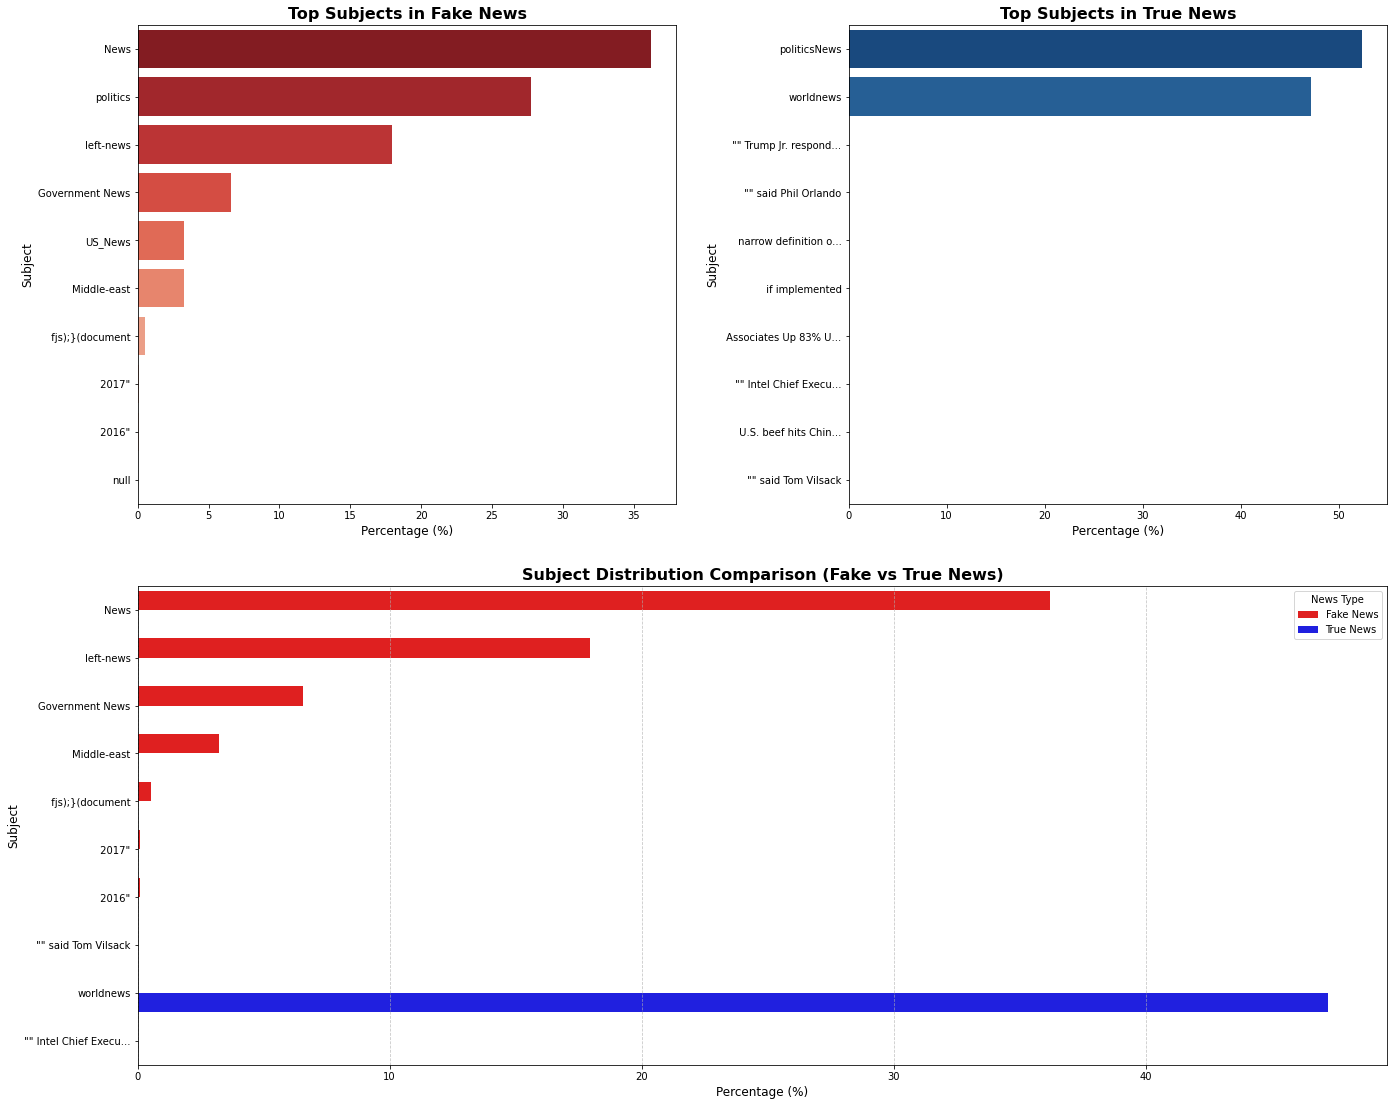


🔴 DATA LEAKAGE RISK ASSESSMENT: HIGH (Score: 10/10)

📋 SUMMARY:
• Analyzed 730 unique subjects in fake news and 94 in true news
• Top 10 subjects cover 95.7% of fake news and 99.6% of true news
• Found 0 common subjects among top 10 in both categories
• 10 subjects appear exclusively in fake news (covering 95.7%)
• 10 subjects appear exclusively in true news (covering 99.6%)

🔍 EVIDENCE OF DATA LEAKAGE:
  1. Top subjects have almost no overlap between fake and true news
  2. 10 subjects are exclusive to fake news, covering 95.7% of fake news
  3. 10 subjects are exclusive to true news, covering 99.6% of true news

⚠️ RECOMMENDATION:
  The 'subject' column MUST be removed before model training to prevent data leakage.

🛑 ACTION REQUIRED:
  df = df.drop('subject')  # Remove the subject column to prevent data leakage

Out[20]: {'has_subject': True,
 'risk_level': 'HIGH',
 'risk_score': 10,
 'recommendation': "The 'subject' column MUST be removed before model training to prevent data leak

In [0]:
analyze_subject_distribution(fake_df, true_df)

Need to drop 'subject' as this field descriminates betweeb fake and true 

In [0]:
# Combine true and fake news datasets
combined_df = combine_datasets(true_df, fake_df)

Combining true and fake news datasets...
Common columns: {'date', 'label', 'subject', 'text', 'title'}
Combined dataset: 44906 records
Label distribution:
+-----+-----+
|label|count|
+-----+-----+
|    1|21417|
|    0|23489|
+-----+-----+



In [0]:
display(combined_df.limit(1000
))

title text label As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support education, scientific research, infrastructure, public health and environmental protection. “The (Trump) administration has already been willing to say: ‘We’re going to increase non-defense discretionary spending ... by about 7 percent,’” Meadows, chairman of the small but influential House Freedom Caucus, said on the program. “Now, Democrats are saying that’s not enough, we need to give the government a pay raise of 10 to 11 percent. For a fiscal conservative, I don’t see where the rationale is. ... Eventually you run out of other people’s money,” he said. Meadows was among Republicans who voted in late December for their party’s debt-financed tax overhaul, which is expected to balloon the federal budget deficit and add about $1.5 trillion over 10 years to the $20 trillion national debt. “It’s interesting to hear Mark talk about fiscal responsibility,” Democratic U.S. Representative Joseph Crowley said on CBS. Crowley said the Republican tax bill would require the United States to borrow $1.5 trillion, to be paid off by future generations, to finance tax cuts for corporations and the rich. “This is one of the least ... fiscally responsible bills we’ve ever seen passed in the history of the House of Representatives. I think we’re going to be paying for this for many, many years to come,” Crowley said. Republicans insist the tax package, the biggest U.S. tax overhaul in more than 30 years, will boost the economy and job growth. House Speaker Paul Ryan, who also supported the tax bill, recently went further than Meadows, making clear in a radio interview that welfare or “entitlement reform,” as the party often calls it, would be a top Republican priority in 2018. In Republican parlance, “entitlement” programs mean food stamps, housing assistance, Medicare and Medicaid health insurance for the elderly, poor and disabled, as well as other programs created by Washington to assist the needy. Democrats seized on Ryan’s early December remarks, saying they showed Republicans would try to pay for their tax overhaul by seeking spending cuts for social programs. But the goals of House Republicans may have to take a back seat to the Senate, where the votes of some Democrats will be needed to approve a budget and prevent a government shutdown. Democrats will use their leverage in the Senate, which Republicans narrowly control, to defend both discretionary non-defense programs and social spending, while tackling the issue of the “Dreamers,” people brought illegally to the country as children. Trump in September put a March 2018 expiration date on the Deferred Action for Childhood Arrivals, or DACA, program, which protects the young immigrants from deportation and provides them with work permits. The president has said in recent Twitter messages he wants funding for his proposed Mexican border wall and other immigration law changes in exchange for agreeing to help the Dreamers. Representa

In [0]:
# Preprocess text data
combined_df = preprocess_text(combined_df)

Starting text preprocessing...
• Extracting 'location' and 'news_source' from 'text' column...
• 'location' and 'news_source' columns added (if pattern found).
• Applying acronym normalization to 2 column(s): text, title
  - Applied acronym normalization to 'text'.
  - Applied acronym normalization to 'title'.
• Applying general text preprocessing to 2 column(s)
  - Applied full preprocessing chain to 'text'.
  - Applied full preprocessing chain to 'title'.

'subject' column not found, no data leakage prevention needed for this column.
• Caching the preprocessed DataFrame for optimized downstream operations.
Text preprocessing complete.


In [0]:
display(combined_df.limit(100))

title text label location news_source as us budget fight looms republicans flip their fiscal script the head of a conservative republican faction in the us congress who voted this month for a huge expansion of the national debt to pay for tax cuts called himself a fiscal conservative on sunday and urged budget restraint in 2018 in keeping with a sharp pivot under way among republicans us representative mark meadows speaking on cbs face the nation drew a hard line on federal spending which lawmakers are bracing to do battle over in january when they return from the holidays on wednesday lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues such as immigration policy even as the november congressional election campaigns approach in which republicans will seek to keep control of congress president donald trump and his republicans want a big budget increase in military spending while democrats also want proportional increases for non defense discretionary spending on programs that support education scientific research infrastructure public health and environmental protection the trump administration has already been willing to say we re going to increase non defense discretionary spending by about 7 percent meadows chairman of the small but influential house freedom caucus said on the program now democrats are saying that s not enough we need to give the government a pay raise of 10 to 11 percent for a fiscal conservative i don t see where the rationale is eventually you run out of other people s money he said meadows was among republicans who voted in late december for their party s debt financed tax overhaul which is expected to balloon the federal budget deficit and add about 1 5 trillion over 10 years to the 20 trillion national debt it s interesting to hear mark talk about fiscal responsibility democratic us representative joseph crowley said on cbs crowley said the republican tax bill would require the united states to borrow 1 5 trillion to be paid off by future generations to finance tax cuts for corporations and the rich this is one of the least fiscally responsible bills we ve ever seen passed in the history of the house of representatives i think we re going to be paying for this for many many years to come crowley said republicans insist the tax package the biggest us tax overhaul in more than 30 years will boost the economy and job growth house speaker paul ryan who also supported the tax bill recently went further than meadows making clear in a radio interview that welfare or entitlement reform as the party often calls it would be a top republican priority in 2018 in republican parlance entitlement programs mean food stamps housing assistance medicare and medicaid health insurance for the elderly poor and disabled as well as other programs created by washington to assist the needy democrats seized on ryan s early december remarks saying they showed republicans would try to pay for their tax overhaul by seeking spending cuts for social programs but the goals of house republicans may have to take a back seat to the senate where the votes of some democrats will be needed to approve a budget and prevent a government shutdown democrats will use their leverage in the senate which republicans narrowly control to defend both discretionary non defense programs and social spending while tackling the issue of the dreamers people brought illegally to the country as children trump in september put a march 2018 expiration date on the deferred action for childhood arrivals or daca program which protects the young immigrants from deportation and provides them with work permits the president has said in recent twitter messages he wants funding for his proposed mexican border wall and other immigration law changes in exchange for agreeing to help the dreamers representative debbie dingell told cbs she did not favor linking that issue to other policy objectives such as wall funding we need 

In [0]:
# Save combined dataset to Parquet
save_to_parquet(combined_df, f"{directories['processed_data']}/combined_news.parquet", partition_by="label")

Saving DataFrame to /dbfs/FileStore/fake_news_detection/data/processed/combined_news.parquet...
DataFrame saved to /dbfs/FileStore/fake_news_detection/data/processed/combined_news.parquet


In [0]:
# Save to Hive tables
save_to_hive_table(combined_df, "combined_news", partition_by="label")

Safely saving DataFrame to Hive table: combined_news
Checking if location exists: dbfs:/user/hive/warehouse/combined_news
Location exists. Removing directory: dbfs:/user/hive/warehouse/combined_news
Directory removed successfully.
Saving DataFrame to table 'combined_news'...
DataFrame saved to table 'combined_news' with partitioning on 'label'.
Verified: Table 'combined_news' exists.

Table information:
+-----------------------+---------+-------+
|col_name               |data_type|comment|
+-----------------------+---------+-------+
|title                  |string   |null   |
|text                   |string   |null   |
|location               |string   |null   |
|news_source            |string   |null   |
|label                  |int      |null   |
|# Partition Information|         |       |
|# col_name             |data_type|comment|
|label                  |int      |null   |
+-----------------------+---------+-------+


Record count: 44,906
Out[27]: True

# Memory Management for Community Edition


Since we're working with the Databricks Community Edition (15.3 GB Memory, 2 Cores), we need to be careful about memory usage. Let's check the size of our datasets and implement memory-efficient processing strategies. We will try to:

1. Process data in smaller batches when possible
2. Use .unpersist() to release cached DataFrames when no longer needed
3. Consider using sampling for exploratory analysis and model development
4. Minimize the number of wide transformations (joins, groupBy, etc.)


In [0]:
# Check dataset sizes
real_count = real_df.count()
fake_count = fake_df.count()
total_count = real_count + fake_count

print(f"Real news dataset: {real_count} records")
print(f"Fake news dataset: {fake_count} records")
print(f"Total dataset size: {total_count} records")
